In [52]:
import os
import gc
import cv2
import timm
import time
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from PIL import Image
import albumentations
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.mount('/content/drive')

In [2]:
train = pd.read_csv('./data/understanding_clouds/train.csv')
train['Image'] = train['Image_Label'].map(lambda x: x.split('.')[0])
train['Label'] = train['Image_Label'].map(lambda x: x.split('_')[1])
train.head()

Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                NaN   
3   0011165.jpg_Sugar                                                NaN   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   

     Image   Label  
0  0011165    Fish  
1  0011165  Flower  
2  0011165  Gravel  
3  0011165   Sugar  
4  002be4f    Fish

In [3]:
train2 = pd.DataFrame({'Image':train['Image'][::4]})
train2.head()

Image
0   0011165
4   002be4f
8   0031ae9
12  0035239
16  003994e

In [4]:
train2['e1'] = train['EncodedPixels'][::4].values
train2['e2'] = train['EncodedPixels'][1::4].values
train2['e3'] = train['EncodedPixels'][2::4].values
train2['e4'] = train['EncodedPixels'][3::4].values
train2.head()

Image                                                 e1  \
0   0011165  264918 937 266318 937 267718 937 269118 937 27...   
4   002be4f  233813 878 235213 878 236613 878 238010 881 23...   
8   0031ae9  3510 690 4910 690 6310 690 7710 690 9110 690 1...   
12  0035239                                                NaN   
16  003994e  2367966 18 2367985 2 2367993 8 2368002 62 2369...   

                                                   e2  \
0   1355565 1002 1356965 1002 1358365 1002 1359765...   
4   1339279 519 1340679 519 1342079 519 1343479 51...   
8   2047 703 3447 703 4847 703 6247 703 7647 703 9...   
12  100812 462 102212 462 103612 462 105012 462 10...   
16                                                NaN   

                                                   e3  \
0                                                 NaN   
4                                                 NaN   
8                                                 NaN   
12  65400 380 66800 380 68200 380 69600 380 71000 ...   
16  353317 416 354717 416 356117 416 357517 416 35...   

                                                   e4  
0                                                 NaN  
4   67495 350 68895 350 70295 350 71695 350 73095 ...  
8   658170 388 659570 388 660970 388 662370 388 66...  
12                                                NaN  
16  28011 489 29411 489 30811 489 32211 489 33611 ...

In [5]:
train2.set_index('Image',inplace=True,drop=True)
train2.fillna('',inplace=True); 
train2.head()

e1  \
Image                                                        
0011165  264918 937 266318 937 267718 937 269118 937 27...   
002be4f  233813 878 235213 878 236613 878 238010 881 23...   
0031ae9  3510 690 4910 690 6310 690 7710 690 9110 690 1...   
0035239                                                      
003994e  2367966 18 2367985 2 2367993 8 2368002 62 2369...   

                                                        e2  \
Image                                                        
0011165  1355565 1002 1356965 1002 1358365 1002 1359765...   
002be4f  1339279 519 1340679 519 1342079 519 1343479 51...   
0031ae9  2047 703 3447 703 4847 703 6247 703 7647 703 9...   
0035239  100812 462 102212 462 103612 462 105012 462 10...   
003994e                                                      

                                                        e3  \
Image                                                        
0011165                                                      
002be4f                                                      
0031ae9                                                      
0035239  65400 380 66800 380 68200 380 69600 380 71000 ...   
003994e  353317 416 354717 416 356117 416 357517 416 35...   

                                                        e4  
Image                                                       
0011165                                                     
002be4f  67495 350 68895 350 70295 350 71695 350 73095 ...  
0031ae9  658170 388 659570 388 660970 388 662370 388 66...  
0035239                                                     
003994e  28011 489 29411 489 30811 489 32211 489 33611 ...

In [6]:
train2[['d1','d2','d3','d4']] = (train2[['e1','e2','e3','e4']]!='').astype('int8')
train2[['d1','d2','d3','d4']].head()

d1  d2  d3  d4
Image                  
0011165   1   1   0   0
002be4f   1   1   0   1
0031ae9   1   1   0   1
0035239   0   1   1   0
003994e   1   0   1   1

In [7]:
train2.head()

e1  \
Image                                                        
0011165  264918 937 266318 937 267718 937 269118 937 27...   
002be4f  233813 878 235213 878 236613 878 238010 881 23...   
0031ae9  3510 690 4910 690 6310 690 7710 690 9110 690 1...   
0035239                                                      
003994e  2367966 18 2367985 2 2367993 8 2368002 62 2369...   

                                                        e2  \
Image                                                        
0011165  1355565 1002 1356965 1002 1358365 1002 1359765...   
002be4f  1339279 519 1340679 519 1342079 519 1343479 51...   
0031ae9  2047 703 3447 703 4847 703 6247 703 7647 703 9...   
0035239  100812 462 102212 462 103612 462 105012 462 10...   
003994e                                                      

                                                        e3  \
Image                                                        
0011165                                                      
002be4f                                                      
0031ae9                                                      
0035239  65400 380 66800 380 68200 380 69600 380 71000 ...   
003994e  353317 416 354717 416 356117 416 357517 416 35...   

                                                        e4  d1  d2  d3  d4  
Image                                                                       
0011165                                                      1   1   0   0  
002be4f  67495 350 68895 350 70295 350 71695 350 73095 ...   1   1   0   1  
0031ae9  658170 388 659570 388 660970 388 662370 388 66...   1   1   0   1  
0035239                                                      0   1   1   0  
003994e  28011 489 29411 489 30811 489 32211 489 33611 ...   1   0   1   1

In [8]:
image_id = train2.index[0]
image_id

'0011165'

In [9]:
target_cols = train2.iloc[:, 4:8].columns.tolist()
target_cols

['d1', 'd2', 'd3', 'd4']

In [10]:
class CloudDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.labels = self.df[target_cols].values
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_id = self.df.index[index]
        path = f'./data/understanding_clouds/train_images/{image_id}.jpg'
        if os.path.exists(path):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
            if self.transform is not None:
                res = self.transform(image=img)
                img = res['image']

            img = img.astype(np.float32)
            img = img.transpose(2,0,1)
            label = torch.tensor(self.labels[index]).float()
        
            return torch.tensor(img).float(), label

In [12]:
transforms_train = albumentations.Compose([
  albumentations.Resize(352, 512, interpolation = cv2.INTER_AREA),
  albumentations.HorizontalFlip(p=0.5),
  albumentations.VerticalFlip(p=0.5),
  albumentations.Normalize(),
])

transforms_valid = albumentations.Compose([
  albumentations.Resize(352, 512, interpolation = cv2.INTER_AREA),
  albumentations.Normalize(),
])

In [13]:
train_ds = CloudDataset(train2, transform=transforms_train)
x,y = train_ds[0]
print(x.shape, y.shape)

In [16]:
train_image = CloudDataset(train2[:1000], transform=transforms_train)
x, y = train_image[0]

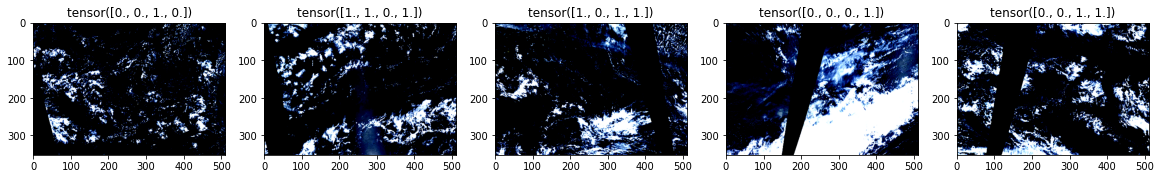

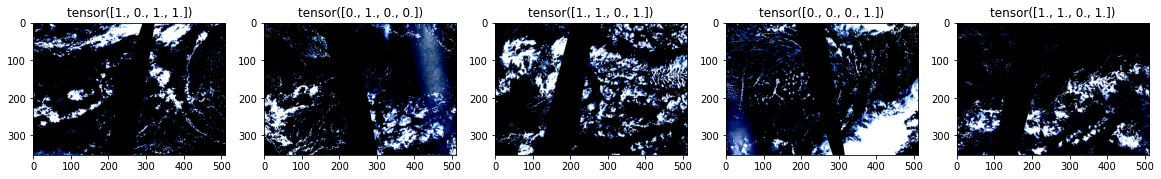

In [17]:
train_image = CloudDataset(train2[:1000], transform=transforms_train)

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
for i in range(2):
    f, axarr = plt.subplots(1, 5)
    for p in range(5):
        idx = np.random.randint(0, len(train_image))
        img, lbl = train_image[idx]
        axarr[p].imshow(img.transpose(0, 1).transpose(1, 2))
        axarr[p].set_title(lbl)

In [18]:
# class modified_resnet50(nn.Module):
#     def __init__(self, model):
#         super(modified_resnet50, self).__init__()
        
#         self.features = list(model.children())[:-2]
#         self.features = nn.Sequential(*self.features)
#         # for param in self.features.parameters():
#         #     param.requires_grad = False
#         self.pooling = model.global_pool
#         self.fc = nn.Linear(in_features=2048, out_features=4)
    
#     def forward(self, x):
#         # for param in self.features.parameters():
#         #     param.requires_grad = False
#         out = self.features(x)
#         out = self.pooling(out)
#         out = self.fc(out)
#         return out

In [19]:
num_gpu = torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = timm.create_model('resnet50', pretrained=True)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 2)
criterion = nn.BCEWithLogitsLoss()

trn, tst = train_test_split(train2, random_state=42, test_size=0.2)
print(trn.shape, tst.shape)

train_ds = CloudDataset(trn, transform=transforms_train)
valid_ds = CloudDataset(tst, transform=transforms_valid)

print(len(train_ds), len(valid_ds))

train_loader = DataLoader(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=8, num_workers=4, shuffle=False)

In [23]:
def train_func(train_loader):
    model.train()
    bar = tqdm(train_loader)
    scaler = torch.cuda.amp.GradScaler()
    losses = []
    for batch_idx, (images, targets) in enumerate(bar):
        images, targets = images.to(device), targets.to(device)
 
        with torch.cuda.amp.autocast():
            logits = model(images)
            loss = criterion(logits, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
  
        losses.append(loss.item())
        smooth_loss = np.mean(losses[-30:])

        bar.set_description(f'loss: {loss.item():.5f}, smth: {smooth_loss:.5f}')

    loss_train = np.mean(losses)
    return loss_train

def valid_func(valid_loader):
    model.eval()
    bar = tqdm(valid_loader)

    PROB = []
    TARGETS = []
    losses = []
    PREDS = []

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(bar):

            images, targets = images.to(device), targets.to(device)
            logits = model(images)

            PREDS += [logits.sigmoid()]
            TARGETS += [targets.detach().cpu()]

            loss = criterion(logits, targets)
            losses.append(loss.item())
            smooth_loss = np.mean(losses[-30:])
            bar.set_description(f'loss: {loss.item():.5f}, smth: {smooth_loss:.5f}')

    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    loss_valid = np.mean(losses)
    
    preds = np.array(PREDS) >= 0.5
    targs = np.array(TARGETS) 
    accuracy = (targs == preds).mean() * 100
    
    return loss_valid, accuracy

In [25]:
best_acc = 0
kernel_type = 'resnet50_frozen'

for epoch in range(2):
    loss_train = train_func(train_loader)
    scheduler.step(epoch)
    loss_valid, accuracy = valid_func(valid_loader)
    
    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, loss_train: {loss_train:.5f}, loss_valid: {loss_valid:.5f}, accuracy: {accuracy:.6f}.'
    print(content)
    
    if accuracy > best_acc:
        print(f'accuracy ({best_acc:.6f} --> {accuracy:.6f}). Saving model ...')
        torch.save(model.state_dict(), f'./drive/MyDrive/understanding_clouds_models/{kernel_type}_best_acc.pth')
        best_acc = accuracy     

loss: 0.73344, smth: 0.53631: 100%|██████████| 139/139 [00:32<00:00,  4.32it/s]


Wed Aug 17 02:06:32 2022 Epoch 0, lr: 0.0010000, loss_train: 0.57666, loss_valid: 0.54050, accuracy: 72.950450.
accuracy (0.000000 --> 72.950450). Saving model ...


loss: 0.87268, smth: 0.60889: 100%|██████████| 139/139 [00:31<00:00,  4.39it/s]

Wed Aug 17 02:09:17 2022 Epoch 1, lr: 0.0005000, loss_train: 0.53500, loss_valid: 0.61252, accuracy: 69.211712.


In [26]:
model = timm.create_model('resnet50', pretrained=True)
model.load_state_dict(torch.load(f'./drive/MyDrive/understanding_clouds_models/resnet50_frozen_best_acc.pth'))
model = model.to(device)

# check to see if frozen or not
# for name, param in model.named_parameters():
#     print('Name: ', name, 'Requires_Grad: ', param.requires_grad)

# for param in model.features.parameters():
#     param.requires_grad = True

# unfreeze layers
# for name, param in model.named_parameters():
#     print('Name: ', name, 'Requires_Grad: ', param.requires_grad)

optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-6)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 2)
criterion = nn.BCEWithLogitsLoss()

In [27]:
best_acc = 0
kernel_type = 'resnet50_unfrozen'

for epoch in range(2):
    loss_train = train_func(train_loader)
    scheduler.step(epoch)
    loss_valid, accuracy = valid_func(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, loss_train: {loss_train:.5f}, loss_valid: {loss_valid:.5f}, accuracy: {accuracy:.6f}.'
    print(content)
    
    if accuracy > best_acc:
        print(f'accuracy ({best_acc:.6f} --> {accuracy:.6f}). Saving model ...')
        torch.save(model.state_dict(), f'./drive/MyDrive/understanding_clouds_models/{kernel_type}_best_acc.pth')
        best_acc = accuracy

loss: 0.64096, smth: 0.51142: 100%|██████████| 139/139 [00:40<00:00,  3.39it/s]


Wed Aug 17 02:12:35 2022 Epoch 0, lr: 0.0002000, loss_train: 0.51190, loss_valid: 0.50277, accuracy: 73.963964.
accuracy (0.000000 --> 73.963964). Saving model ...


loss: 0.68492, smth: 0.50180: 100%|██████████| 139/139 [00:32<00:00,  4.33it/s]


Wed Aug 17 02:15:26 2022 Epoch 1, lr: 0.0001000, loss_train: 0.49913, loss_valid: 0.49787, accuracy: 75.247748.
accuracy (73.963964 --> 75.247748). Saving model ...


In [28]:
model = timm.create_model('resnet50', pretrained=True)
model.load_state_dict(torch.load(f'./drive/MyDrive/understanding_clouds_models/resnet50_unfrozen_best_acc.pth'))
model = model.to(device)

In [29]:
def oof_func(test_loader):
    model.eval()
    bar = tqdm(test_loader)

    PROB = []
    TARGETS = []
    losses = []
    PREDS = []

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(bar):

            images, targets = images.to(device), targets.to(device)
            logits = model(images)

            PREDS += [logits.sigmoid()]
            TARGETS += [targets.detach().cpu()]

    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
     
    return PREDS, TARGETS

In [30]:
train3 = train2.loc[train2.index.isin(tst.index)].copy()
test_ds = CloudDataset(train3, transform=transforms_valid)
test_loader = DataLoader(test_ds, batch_size=8, num_workers=4, shuffle=False)
oof_PREDS, oof_TARGETS = oof_func(test_loader)

100%|██████████| 139/139 [00:40<00:00,  3.44it/s]


In [31]:
for k in range(1, 5): 
    train3['o'+str(k)] = 0
train3[['o1', 'o2', 'o3', 'o4']] = oof_PREDS
train3.head()

e1  \
Image                                                        
008233e                                                      
009e2f3  65812 93 65906 4 65911 10 67212 96 67309 5 673...   
00bea06  631761 556 633161 556 634561 556 635961 556 63...   
00d4443                                                      
011ba04  2040442 354 2041842 354 2043242 354 2044642 35...   

                                                        e2  \
Image                                                        
008233e                                                      
009e2f3                                                      
00bea06                                                      
00d4443                                                      
011ba04  715401 257 716801 257 718201 257 719601 257 72...   

                                                        e3  \
Image                                                        
008233e                                                      
009e2f3  2257162 1024 2258562 1024 2259962 1024 2261362...   
00bea06  1588602 380 1590002 380 1591402 380 1592802 38...   
00d4443                                                      
011ba04                                                      

                                                        e4  d1  d2  d3  d4  \
Image                                                                        
008233e  910449 829 911849 829 913249 829 914649 829 91...   0   0   0   1   
009e2f3  1057848 360 1059248 360 1060648 360 1062048 36...   1   0   1   1   
00bea06                                                      1   0   1   0   
00d4443  70287 806 71687 806 73087 806 74487 806 75887 ...   0   0   0   1   
011ba04  1 664 1401 664 2801 664 4201 664 5601 664 7001...   1   1   0   1   

               o1        o2        o3        o4  
Image                                            
008233e  0.233974  0.068717  0.941900  0.999926  
009e2f3  0.779415  0.067707  0.535192  0.992469  
00bea06  0.981507  0.024744  0.919749  0.428633  
00d4443  0.535302  0.283334  0.868179  0.826992  
011ba04  0.368721  0.618857  0.431818  0.801094

In [32]:
# COMPUTE ACCURACY AND ROC_AUC_SCORE
types = ['Fish','Flower','Gravel','Sugar']
for k in range(1,5):
    print(types[k-1],': ',end='')
    auc = np.round( roc_auc_score(train3['d'+str(k)].values,train3['o'+str(k)].values  ),3 )
    acc = np.round( accuracy_score(train3['d'+str(k)].values,(train3['o'+str(k)].values>0.5).astype(int) ),3 )
    print('AUC =', auc, end='')
    print(', ACC =', acc) 
print('OVERALL: ', end='')
auc = np.round( roc_auc_score(train3[['d1','d2','d3','d4']].values.reshape((-1)), train3[['o1','o2','o3','o4']].values.reshape((-1)) ), 3 )
acc = np.round( accuracy_score(train3[['d1','d2','d3','d4']].values.reshape((-1)), (train3[['o1','o2','o3','o4']].values>0.5).astype(int).reshape((-1)) ), 3 )
print('AUC =',auc, end='')
print(', ACC =',acc) 

Fish : AUC = 0.8, ACC = 0.709
Flower : AUC = 0.913, ACC = 0.827
Gravel : AUC = 0.794, ACC = 0.715
Sugar : AUC = 0.808, ACC = 0.759
OVERALL: AUC = 0.838, ACC = 0.752


In [33]:
def rle2maskX(mask_rle, shape=(2100,1400), shrink=1):
    # Converts rle to mask size shape then downsamples by shrink
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T[::shrink,::shrink]

def rle2mask2X(mask_rle, shape=(2100,1400), shrink=(512,352)):
    # Converts rle to mask size shape then downsamples by shrink
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    img = img.reshape(shape).T
    img = Image.fromarray(img)
    img = img.resize(shrink)
    img = np.array(img)
    return img

def mask2contour(mask, width=5):
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3) 

def mask2rle(img, shape=(525,350)):    
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def dice_coef6(y_true_rle, y_pred_rle, y_pred_prob, th):
    if y_pred_prob<th:
        if y_true_rle=='': return 1
        else: return 0
    else:
        y_true_f = rle2maskX(y_true_rle,shrink=4)
        y_pred_f = rle2maskX(y_pred_rle,shape=(525,350))
        union = np.sum(y_true_f) + np.sum(y_pred_f)
        if union==0: return 1
        intersection = np.sum(y_true_f * y_pred_f)
        return 2. * intersection / union

def dice_coef8(y_true_f, y_pred_f):
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


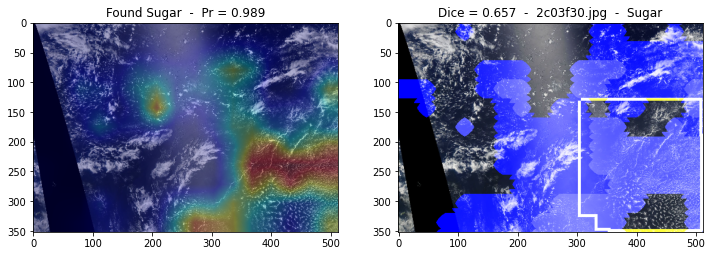

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


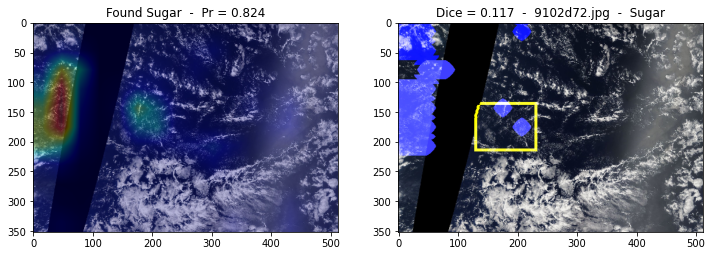

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


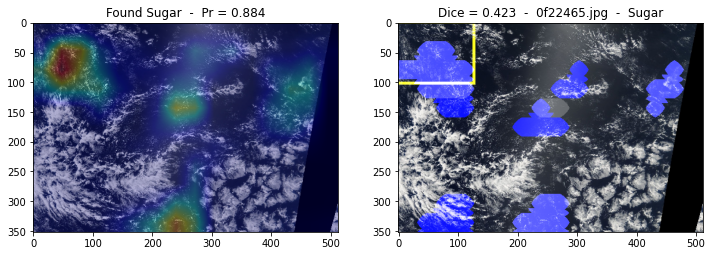

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


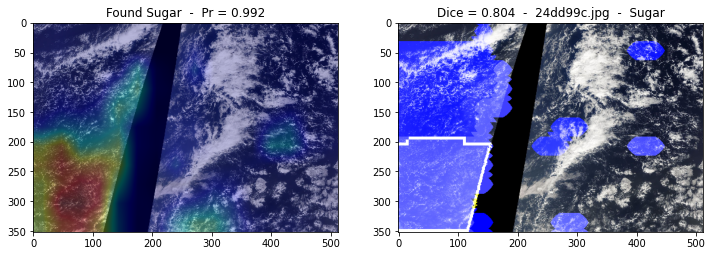

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


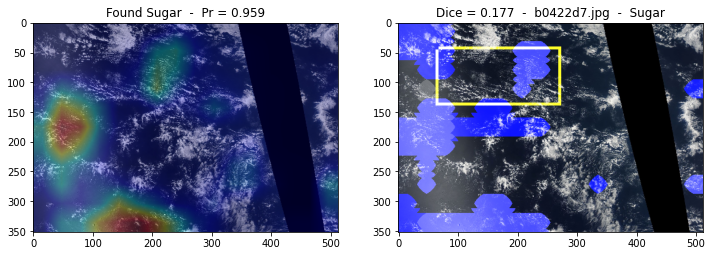

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


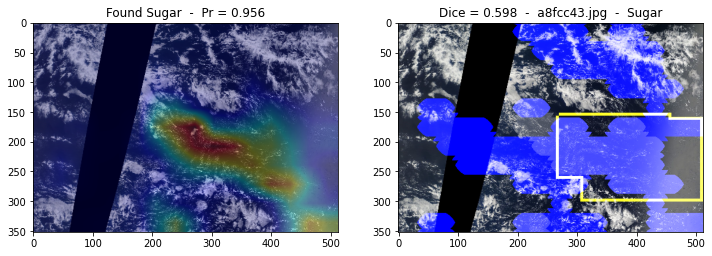

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


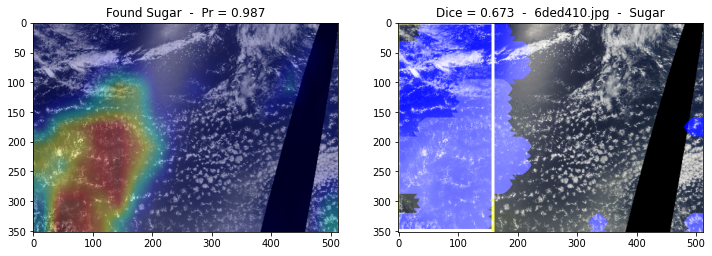

torch.Size([1, 2048, 11, 16])
1
Heatmap:  (11, 16)


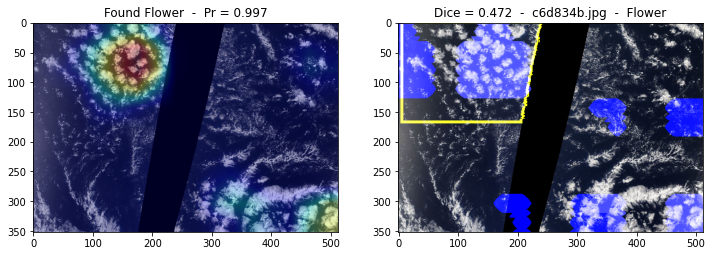

torch.Size([1, 2048, 11, 16])
2
Heatmap:  (11, 16)


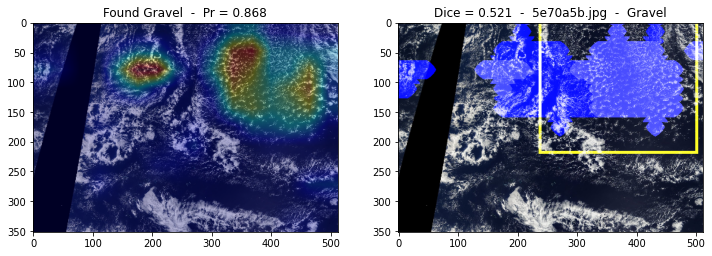

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


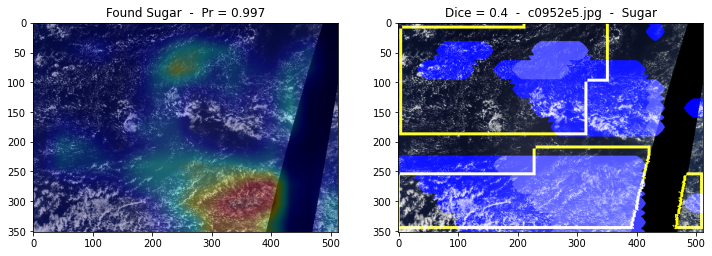

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


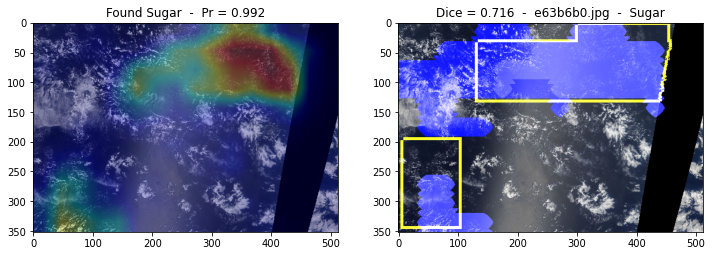

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


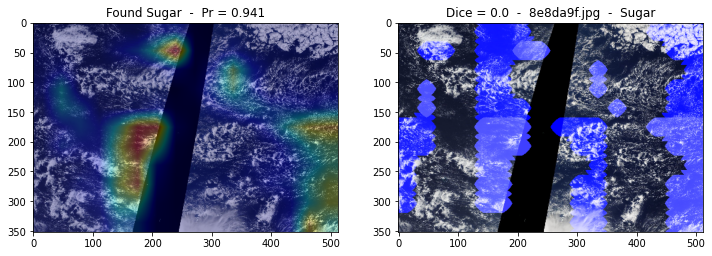

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


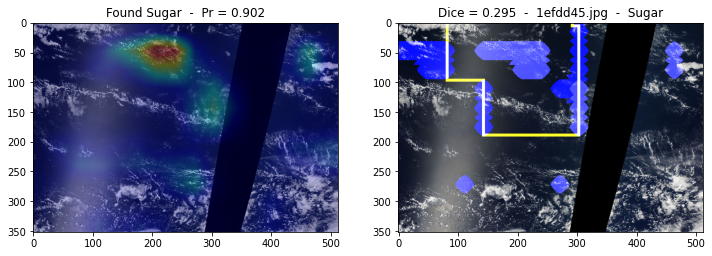

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


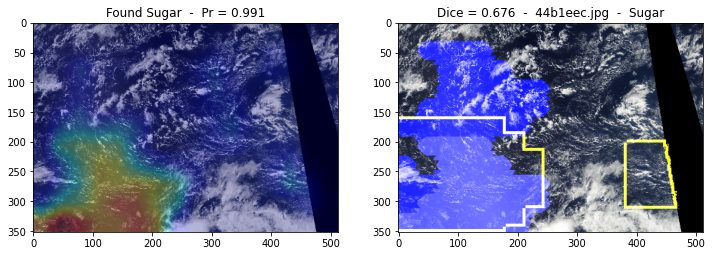

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


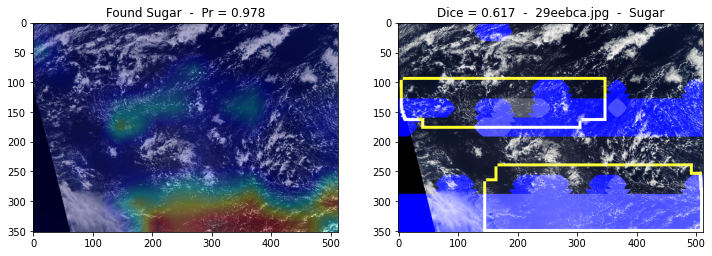

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


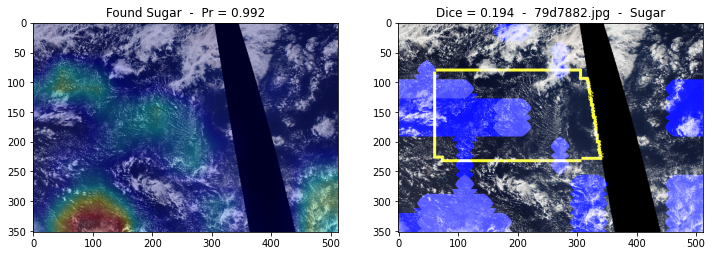

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


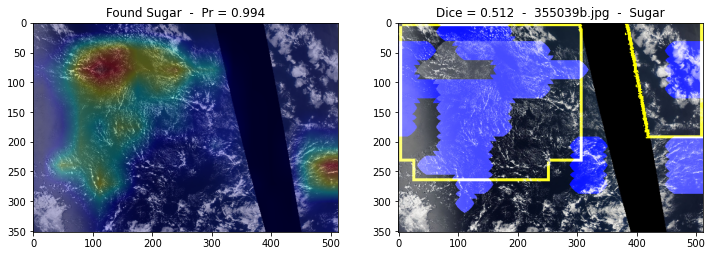

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


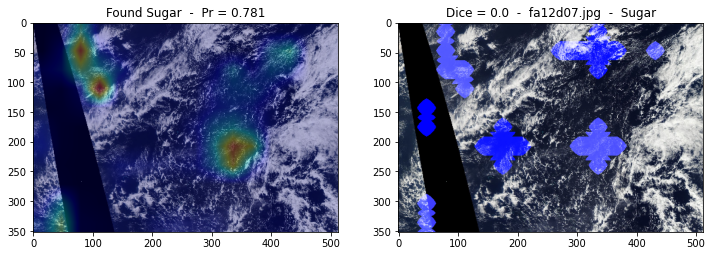

torch.Size([1, 2048, 11, 16])
1
Heatmap:  (11, 16)


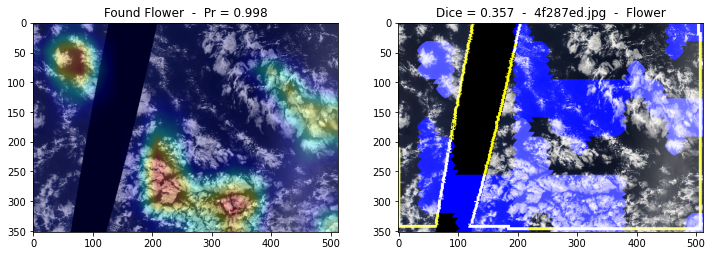

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


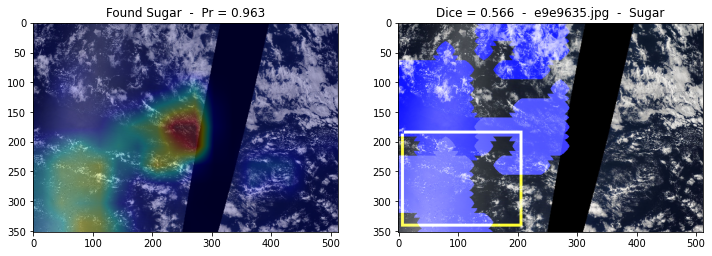

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


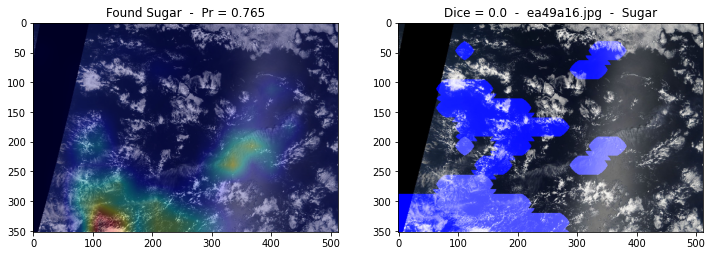

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


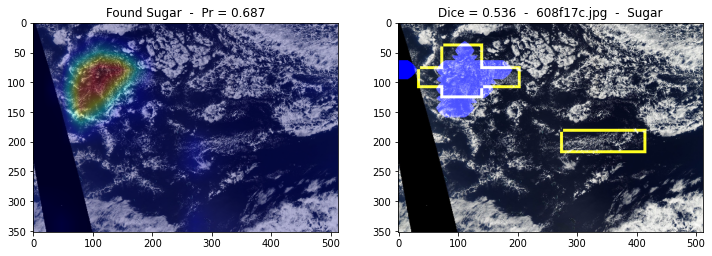

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


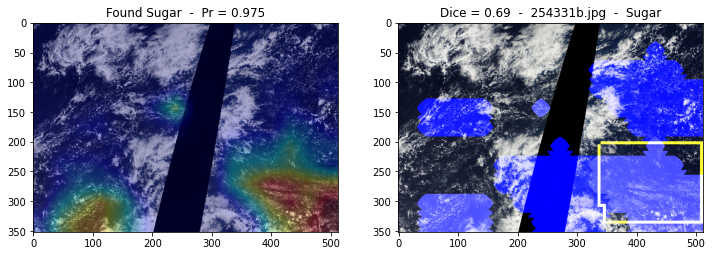

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


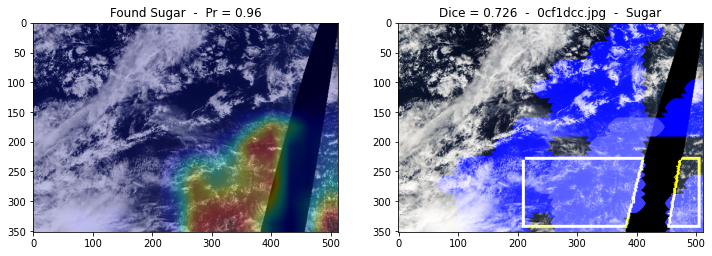

torch.Size([1, 2048, 11, 16])
3
Heatmap:  (11, 16)


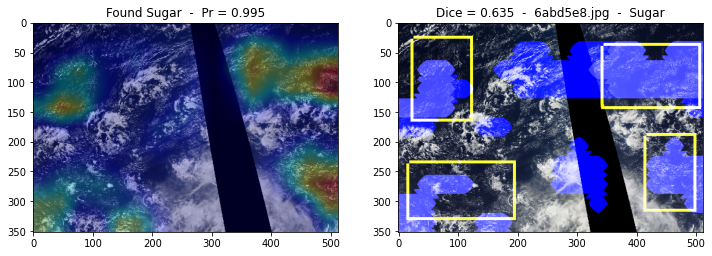

In [42]:
# DISPLAY 25 RANDOM IMAGES
PATH = './data/understanding_clouds/train_images/'
IMGS = os.listdir(PATH)

types = ['Fish','Flower','Gravel','Sugar']

for k in np.random.randint(0,5000,25):
  # LOAD IMAGE AND PREDICT CLASS ACTIVATION MAP
  img = cv2.resize( cv2.imread(PATH+IMGS[k]), (512, 352))
  img = transforms_valid(image=img)['image']
  img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1).unsqueeze(0).cuda()

  feat = list(model.children())[:-2]
  feat = nn.Sequential(*feat)

  for param in feat.parameters():
      param.requires_grad = True

  feat.eval()
  feat.zero_grad()

  def __extract(grad):
      global feature_grad
      feature_grad = grad

  x = feat(img)
  features = x
  print(x.shape)

  # hook for the gradients
  def __extract_grad(grad):
      global feature_grad
      feature_grad = grad
  features.register_hook(__extract_grad)

  # get the output from the whole VGG architecture
  x = model.pooling(x) # torch.Size([1, 512])
  output = model.fc(x) # torch.Size([1, 4])
  o2 = output.sigmoid()
  o2 = o2.cpu().detach().numpy()
  pred = torch.argmax(output).item()
  print(pred)

  # get the gradient of the output
  output[:, pred].backward()

  # pool the gradients across the channels
  pooled_grad = torch.mean(feature_grad, dim=[0, 2, 3])

  # weight the channels with the corresponding gradients
  # (L_Grad-CAM = alpha * A)
  features = features.detach()
  for i in range(features.shape[1]):
      features[:, i, :, :] *= pooled_grad[i] 
    
  # average the channels and create an heatmap
  # ReLU(L_Grad-CAM)
  heatmap = torch.mean(features, dim=1).squeeze()
  heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)

  # normalization for plotting
  heatmap = torch.tensor(heatmap) / torch.max(torch.tensor(heatmap))
  heatmap = heatmap.numpy()

  mask0 = (heatmap>0.3).astype(int)
  contour0 = mask2contour(mask0,5).astype(np.uint8)
  _contour0 = cv2.resize(contour0, (512, 352))

  plt.figure(figsize=(12,6))
  plt.subplot(1,2,1)

  img = cv2.resize( cv2.imread(PATH+IMGS[k]), (512, 352))
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.4 + img
  superimposed_img = np.uint8(255 * superimposed_img / np.max(superimposed_img))
  superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
  plt.title('Found '+types[pred]+'  -  Pr = '+str(np.round(o2[0,pred],3)) )
  plt.imshow(superimposed_img)

  plt.subplot(1,2,2)

  # DISPLAY IMAGE WITH MASKS
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  rle = train2.loc[IMGS[k].split('.')[0],'e'+str(pred+1)]
  mask = rle2mask2X(rle,shrink=(512,352))
  contour = mask2contour(mask,5)

  img[contour==1,:2] = 255
  img[_contour0==1,2] = 255

  diff = np.ones((352,512,3),dtype=np.int)*255-img
  diff = diff.astype(int)

  mask0 = mask0.astype(np.uint8)
  mask0 = cv2.resize(mask0, (512, 352))

  img=img.astype(int)
  img[mask0==1,:] += diff[mask0==1,:]//4

  plt.imshow( img )
  dice = np.round( dice_coef8(mask,mask0),3 )
  plt.title('Dice = '+str(dice)+'  -  '+IMGS[k]+'  -  '+types[pred])

  plt.show()

In [49]:
for i,f in tqdm(enumerate(train3.index.values), total=len(train3.index.values)):
  for pred in [0,1,2,3]:
    # LOAD IMAGE AND PREDICT CLASS ACTIVATION MAPS
    img = cv2.resize( cv2.imread(PATH+f+'.jpg'), (512, 352))
    img = transforms_valid(image=img)['image']
    img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1).unsqueeze(0).cuda()

    feat = list(model.children())[:-2]
    feat = nn.Sequential(*feat)

    feat.eval()
    feat.zero_grad()

    def __extract(grad):
        global feature_grad
        feature_grad = grad

    x = feat(img)
    features = x

    # hook for the gradients
    def __extract_grad(grad):
        global feature_grad
        feature_grad = grad
    features.register_hook(__extract_grad)

    # get the output from the whole VGG architecture
    x = model.pooling(x) # torch.Size([1, 512])
    output = model.fc(x) # torch.Size([1, 4])
    o2 = output.sigmoid()
    o2 = o2.cpu().detach().numpy()
    # pred = torch.argmax(output).item()
    # print(pred)

    # get the gradient of the output
    output[:, pred].backward()

    # pool the gradients across the channels
    pooled_grad = torch.mean(feature_grad, dim=[0, 2, 3])

    # weight the channels with the corresponding gradients
    # (L_Grad-CAM = alpha * A)
    features = features.detach()
    for i in range(features.shape[1]):
        features[:, i, :, :] *= pooled_grad[i] 

    # average the channels and create an heatmap
    # ReLU(L_Grad-CAM)
    heatmap = torch.mean(features, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)

    # normalization for plotting
    heatmap = torch.tensor(heatmap) / torch.max(torch.tensor(heatmap))
    heatmap = heatmap.cpu().detach().numpy()

    final_output = cv2.resize(heatmap,(525,350))
    train3.loc[f,'p'+str(pred+1)] = mask2rle( (final_output>0.3).astype(int) )
    train3.loc[f,'pp'+str(pred+1)] = o2[0,pred]

100%|██████████| 1110/1110 [08:35<00:00,  2.15it/s]

In [50]:
train3.head()

e1  \
Image                                                        
008233e                                                      
009e2f3  65812 93 65906 4 65911 10 67212 96 67309 5 673...   
00bea06  631761 556 633161 556 634561 556 635961 556 63...   
00d4443                                                      
011ba04  2040442 354 2041842 354 2043242 354 2044642 35...   

                                                        e2  \
Image                                                        
008233e                                                      
009e2f3                                                      
00bea06                                                      
00d4443                                                      
011ba04  715401 257 716801 257 718201 257 719601 257 72...   

                                                        e3  \
Image                                                        
008233e                                                      
009e2f3  2257162 1024 2258562 1024 2259962 1024 2261362...   
00bea06  1588602 380 1590002 380 1591402 380 1592802 38...   
00d4443                                                      
011ba04                                                      

                                                        e4  d1  d2  d3  d4  \
Image                                                                        
008233e  910449 829 911849 829 913249 829 914649 829 91...   0   0   0   1   
009e2f3  1057848 360 1059248 360 1060648 360 1062048 36...   1   0   1   1   
00bea06                                                      1   0   1   0   
00d4443  70287 806 71687 806 73087 806 74487 806 75887 ...   0   0   0   1   
011ba04  1 664 1401 664 2801 664 4201 664 5601 664 7001...   1   1   0   1   

               o1        o2  ...  \
Image                        ...   
008233e  0.233974  0.068717  ...   
009e2f3  0.779415  0.067707  ...   
00bea06  0.981507  0.024744  ...   
00d4443  0.535302  0.283334  ...   
011ba04  0.368721  0.618857  ...   

                                                        p2       pp2  \
Image                                                                  
008233e  32310 14 32658 33 33006 40 33354 44 33702 48 3...  0.186551   
009e2f3  140491 4 140838 8 141184 13 141531 17 141878 2...  0.148205   
00bea06  135530 1 135878 5 136227 7 136575 11 136924 13...  0.130469   
00d4443  108102 2 108450 5 108798 8 109147 9 109497 9 1...  0.428658   
011ba04  6950 25 7298 53 7645 56 7993 58 8341 60 8689 6...  0.597871   

                                                        p3       pp3  \
Image                                                                  
008233e  15384 17 15733 18 16082 19 16431 20 16780 21 1...  0.763566   
009e2f3  35301 5 35650 9 35998 14 36347 17 36695 21 370...  0.373900   
00bea06  11375 2 11725 3 12074 6 12423 8 12772 10 13121...  0.663488   
00d4443  17357 2 17707 2 18057 2 18407 2 18757 3 19107 ...  0.589376   
011ba04  15511 2 15852 12 16193 23 16531 36 16880 38 17...  0.392613   

                                                        p4       pp4  ss1  \
Image                                                                       
008233e  24928 4 25274 9 25620 14 25967 18 26314 23 266...  0.999840  1.0   
009e2f3  25693 2 26039 7 26386 11 26733 15 27080 19 274...  0.995876  0.0   
00bea06  14588 7 14684 17 14937 15 15032 19 15286 22 15...  0.732237  0.0   
00d4443  146 43 496 43 846 43 1196 43 1546 43 1896 43 2...  0.941029  1.0   
011ba04  10668 9 11007 21 11343 37 11691 40 12038 44 12...  0.876124  0.0   

         ss2  ss3  ss4  
Image                   
008233e  1.0  1.0  0.0  
009e2f3  1.0  0.0  0.0  
00bea06  1.0  0.0  1.0  
00d4443  1.0  1.0  0.0  
011ba04  0.0  1.0  0.0  

[5 rows x 24 columns]

In [51]:
# COMPUTE KAGGLE DICE
th = [0.8,0.5,0.7,0.7]
for k in range(1,5):
    train3['ss'+str(k)] = train3.apply(lambda x:dice_coef6(x['e'+str(k)],x['p'+str(k)],x['pp'+str(k)],th[k-1]),axis=1)
    dice = np.round( train3['ss'+str(k)].mean(),3 )
    print(types[k-1],': Kaggle Dice =',dice)
dice = np.round( np.mean( train3[['ss1','ss2','ss3','ss4']].values ),3 )
print('Overall : Kaggle Dice =',dice)

Fish : Kaggle Dice = 0.506
Flower : Kaggle Dice = 0.645
Gravel : Kaggle Dice = 0.509
Sugar : Kaggle Dice = 0.469
Overall : Kaggle Dice = 0.532
